In [24]:
print("Hello world!")

Hello world!


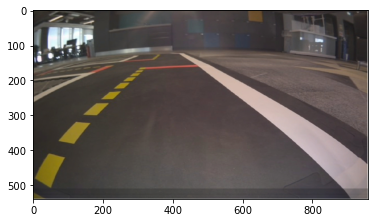

In [65]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#preiau imaginea
image = mpimg.imread('/home/andrei/Documents/Line_following_grayscale/data/poza1.jpg')
plt.imshow(image)

color_select = np.copy(image)
#Decid de la ce culoare vreau sa fac totul negru
red_threshold = 130
green_threshold = 130
blue_threshold = 130

rgb_threshold = [red_threshold,green_threshold,blue_threshold]

thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

<AxesSubplot:title={'center':'Output image'}>

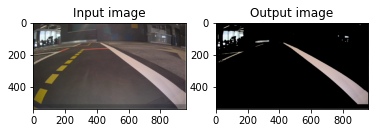

In [66]:
#Functia care afiseaza doua imagini pentru a face comparatii
def display_image(input_image,output_image):
    fig = plt.figure()
    a = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(input_image, cmap='gray')
    a.set_title('Input image')

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(output_image, cmap='gray')
    imgplot.set_clim(0.0, 0.7)
    a.set_title('Output image')
    return a

display_image(image, color_select)


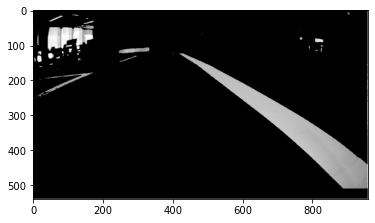

In [67]:
#Transform imaginea din 3 canale de culoare intr-unul singur
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

gray = grayscale(color_select)
plt.imshow(gray,cmap='gray')

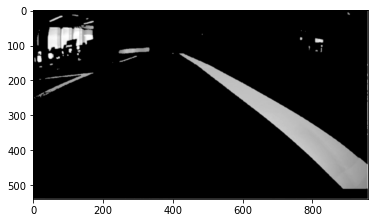

In [68]:
#Gaussian blur
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    dilated_gray = cv2.dilate(img, (kernel_size, kernel_size))
    return cv2.GaussianBlur(dilated_gray, (kernel_size, kernel_size), 0)

kernel_size = 3
dilated_gray = cv2.dilate(gray, (kernel_size, kernel_size))
blur_gray = cv2.GaussianBlur(dilated_gray,(kernel_size, kernel_size),0) 
plt.imshow(blur_gray,cmap='gray')

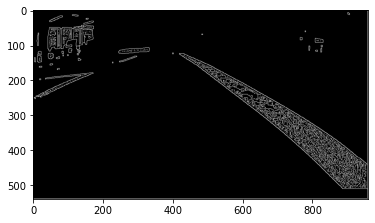

In [69]:
#Aplic algoritmul de Canny Edge Detection
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

edges = canny(blur_gray, 0, 0)
plt.imshow(edges,cmap='gray')

540 960
(60.0, 540) (480.0, 607.5) (900.0, 540) (780.0, 540) (480.0, 641.25) (180.0, 540)


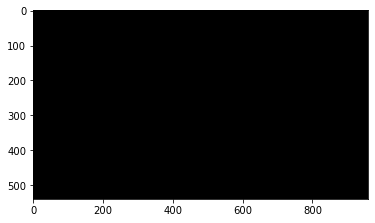

In [80]:
#Marchez zona de interes al liniilor
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255  
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

imshape = image.shape
h,w = imshape[:2]
print(h,w)
vertex = 9*h/8
wstep = w/16
hstep = h/16

tbl = (wstep,h)
ttm = (w/2,vertex)
tbr = (w-wstep,h)

bbr = (w-3*wstep,h)
btm = (w/2,vertex+hstep)
bbl = (3*wstep,h)
print(tbl, ttm, tbr, bbr, btm, bbl)
vertices = np.array([[tbl, ttm, tbr, bbr, btm, bbl]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges,cmap='gray')

In [71]:
#Transformata lui Hough
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    return lines

#distanta dintre pixeli
rho = 1
#unghiul dintre radiani
theta = np.pi/180
threshold = 40
#numarul minim de pixeli care fac o linie 
min_line_length = 20
#numarul maxim de pixeli care despart o linie 
max_line_gap=40

lines = hough_lines(masked_edges,rho,theta,threshold,min_line_length,max_line_gap)

In [72]:
#Desenarea liniilor
def draw_lines(img, lines, ytop, ybot, color=[255, 0, 0], thickness=10, ls=-0.65, rs=0.65, dm=0.15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global frame_no
    global left_lane
    global right_lane
    
    # Segmenting the lines
    left_lines, right_lines = line_segment(lines, ls, rs, dm)

    # average the lines, average with prior lane, and draw
    if left_lines.size is not 0:
        if frame_no is 0:
            left_lane = avg_lines(img, left_lines, ytop, ybot)
        else:
            prior_left_lane = left_lane
            new_left_lane = avg_lines(img, left_lines, ytop, ybot)
            left_lane = np.round(np.average(np.vstack((prior_left_lane, new_left_lane)), axis=0)).astype(int)
    if right_lines.size is not 0:
        if frame_no is 0:
            right_lane = avg_lines(img, right_lines, ytop, ybot)
        else:
            prior_right_lane = right_lane
            new_right_lane = avg_lines(img, right_lines, ytop, ybot)
            right_lane = np.round(np.average(np.vstack((prior_right_lane, new_right_lane)), axis=0)).astype(int)
            
    # draw the lanes; if a new lane was not properly calculated, use the prior lane
    x1, y1, x2, y2 = left_lane
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    x1, y1, x2, y2 = right_lane
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def line_segment(lines, ls, rs, dm):
    
    global frame_no
    # Set slope based on the last lane
    if frame_no is not 0: 
        ls = (left_lane[3] - left_lane[1])/(left_lane[2] - left_lane[0])
        rs = (right_lane[3] - right_lane[1])/(right_lane[2] - right_lane[0])
    # Calculate slopes of all lines
    # m = (y2 - y1)/(x2 - x1)
    slopes = (lines[:,:,3] - lines[:,:,1])/(lines[:,:,2] - lines[:,:,0])

    # lane selector
    left = [(slopes<ls+dm) & (slopes>ls-dm)] 
    right = [(slopes<rs+dm) & (slopes>rs-dm)]
    
    return lines[left], lines[right]

def avg_lines(img, lines, ytop, ybot):    
    """
    This function takes multiple line segments and computes their averages.
    Returns endpoints of the average lines at the boundaries of the image.
    """
    # Average slope
    m = np.average((lines[:,3] - lines[:,1])/(lines[:,2] - lines[:,0]))
    # Average of x values
    x = np.average(np.concatenate((lines[:,0], lines[:,2]))) 
    # Average of y values
    y = np.average(np.concatenate((lines[:,1], lines[:,3]))) 
    b = y - m*x 
    
    # Calculate the x-values at the top and bottom of the lines
    xtop = np.round((ytop-b)/m).astype(int)
    xbot = np.round((ybot-b)/m).astype(int)
    return [xtop, ytop, xbot, ybot]

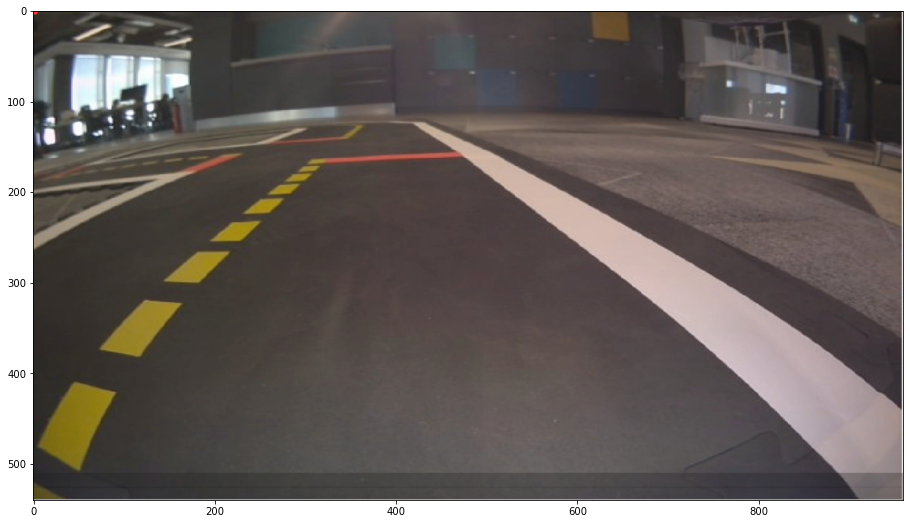

In [73]:
frame_no = 0
left_lane = [0,0,0,0]
right_lane = [0,0,0,0]
lanes = np.zeros((h, w, 3), dtype=np.uint8)
ytop = np.round(19*h/32).astype(int)
ybot = h
draw_lines(lanes, lines, ytop, ybot)

# Deseneaza liniile pe marginea imaginii
# α * img1 + β * img2 + λ
α, β, λ = 1, 1.5, 0 
image_lanes = cv2.addWeighted(image, α, lanes, β, λ)

plt.figure(figsize=(16,9))
plt.imshow(image_lanes)

In [11]:
import os
os.listdir("/home/andrei/Documents/Line_following_grayscale/test_images")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg']

/tmp/ipykernel_3587/1137204636.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lines[left], lines[right]


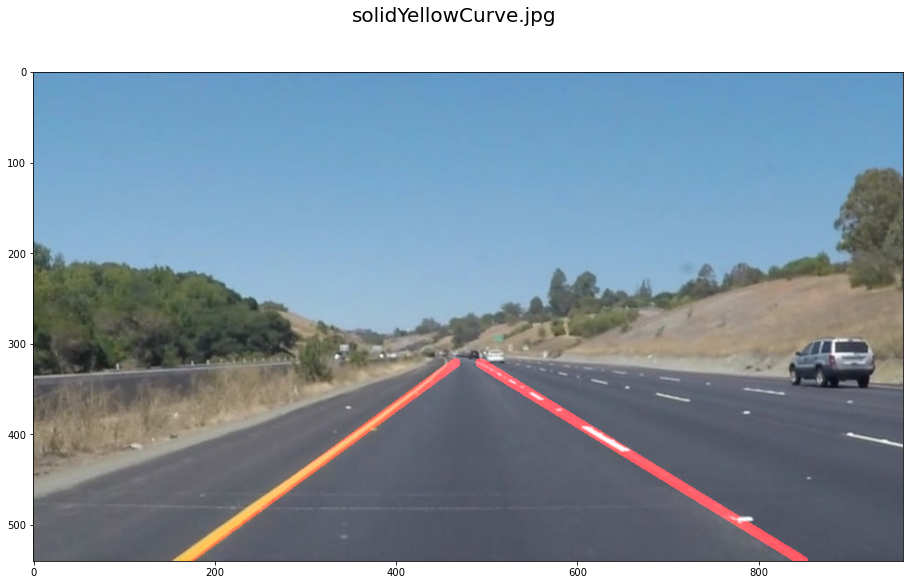

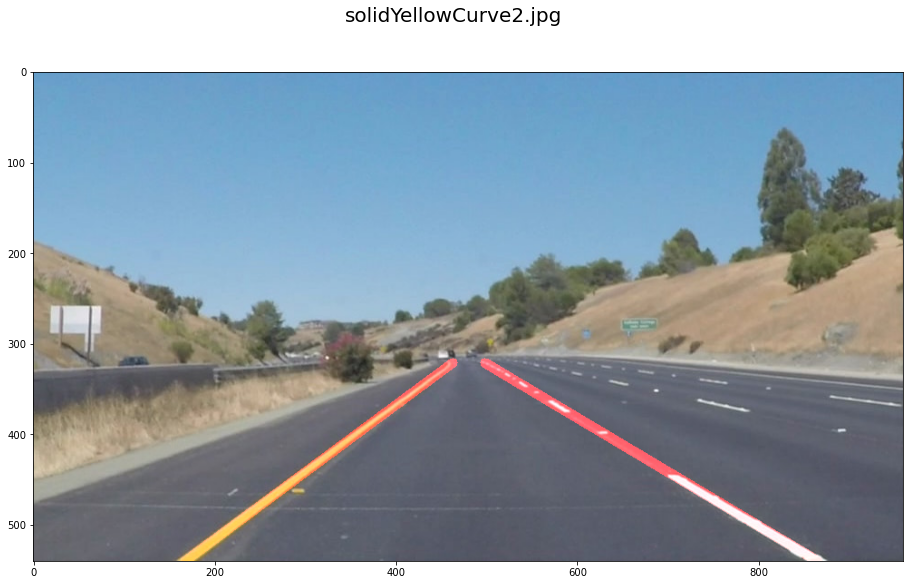

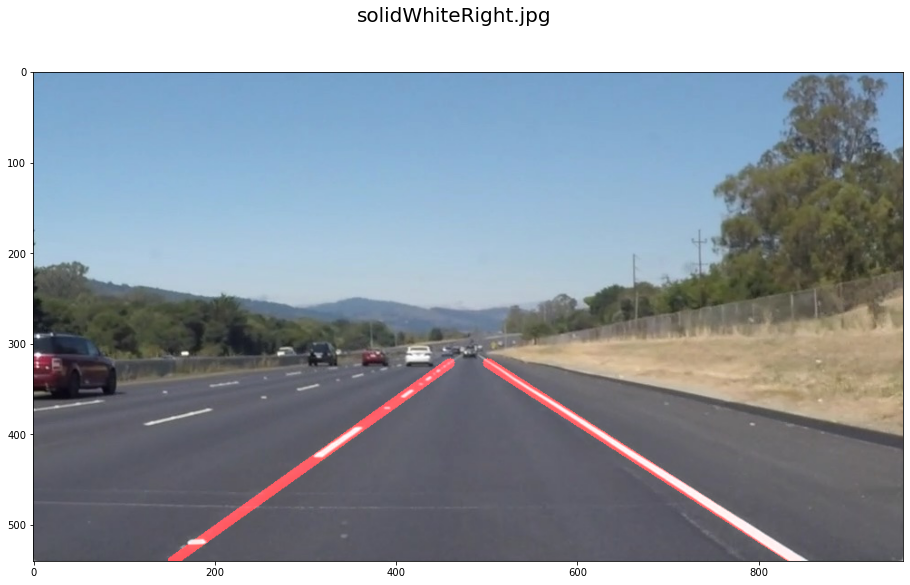

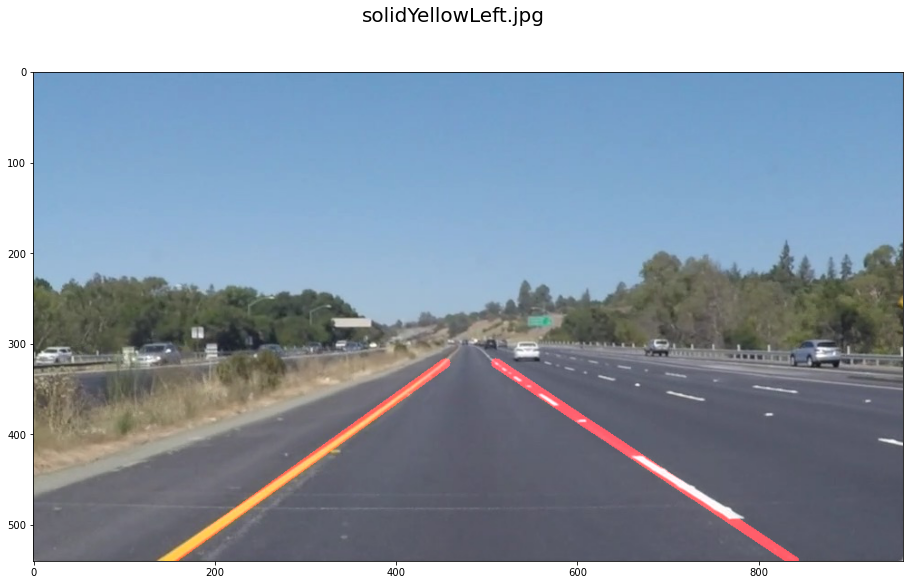

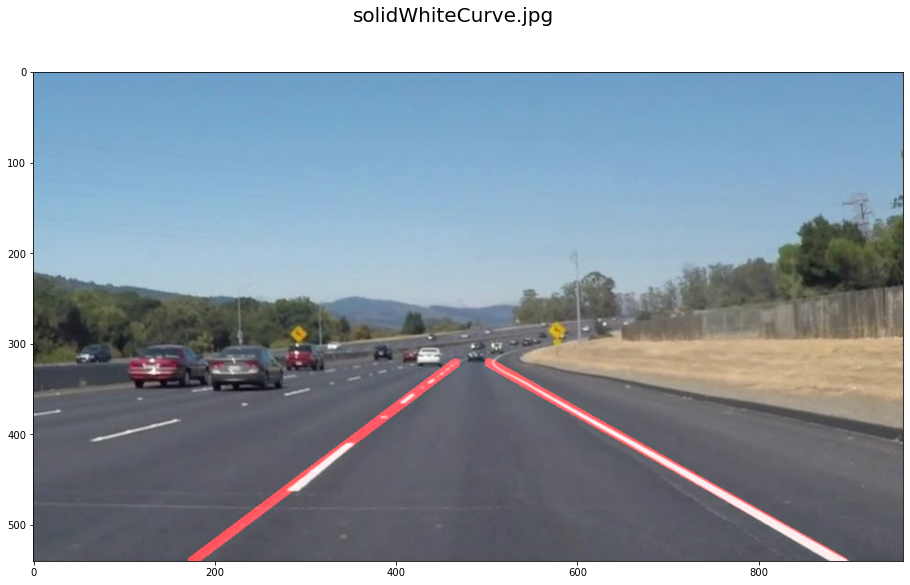

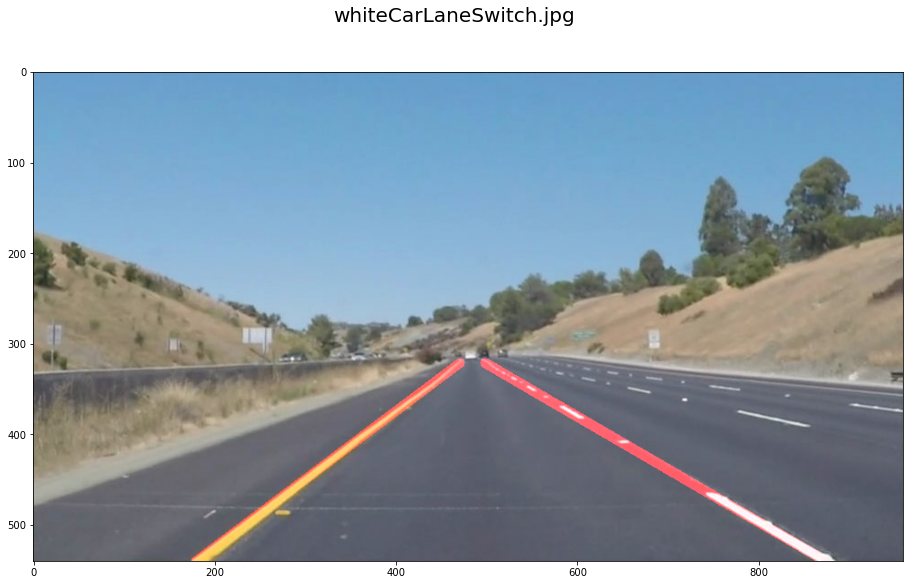

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

# Read in and grayscale the image
img_filenames = os.listdir("/home/andrei/Documents/Line_following_grayscale/test_images/")
for img_filename in img_filenames:
    image = mpimg.imread('/home/andrei/Documents/Line_following_grayscale/test_images/'+img_filename)    
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)    

    frame_no = 0
    left_lane = [0,0,0,0]
    right_lane = [0,0,0,0]

    # Defining a kernel size and apply dilation & Gaussian smoothing
    kernel_size = 3
    dilated_gray = cv2.dilate(gray, (kernel_size, kernel_size))
    blur_gray = cv2.GaussianBlur(dilated_gray,(kernel_size, kernel_size),0)    

    # Defining parameters for Canny edge detection
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)  

    # Defining the region of interest
    imshape = image.shape
    h,w = imshape[:2]

    vertex = 9*h/16
    wstep = w/32
    hstep = h/32

    tbl = (wstep,h)
    ttm = (w/2,vertex)
    tbr = (w-wstep,h)

    bbr = (w-7*wstep,h)
    btm = (w/2,vertex+hstep)
    bbl = (7*wstep,h)

    vertices = np.array([[tbl, ttm, tbr, bbr, btm, bbl]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
   

    # Defining the Hough transform parameters
    
    # Distance resolution in pixels of the grid
    rho = 1        
    # Angular resolution in radians of the grid
    theta = np.pi/180   
    # Intersections in Hough grid cell
    threshold = 40  
    # Minimum number of pixels making up a line
    min_line_length = 20 
    # Maximum gap in pixels between connectable line segments
    max_line_gap = 40    
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)     

    lanes = np.zeros((h, w, 3), dtype=np.uint8)
    ytop = np.round(19*h/32).astype(int)
    ybot = h
    draw_lines(lanes, lines, ytop, ybot)  

    # Draw the lines on the edge image
    # α * img1 + β * img2 + λ
    α, β, λ = 1, 1.5, 0 
    image_lanes = cv2.addWeighted(image, α, lanes, β, λ) 
    
    dirName = 'test_images_output'
    # Create target Directory if don't exist
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")   

    plt.figure(figsize=(16,9))
    plt.imshow(image_lanes)
    plt.suptitle(img_filename, fontsize=20)
    plt.imsave('/home/andrei/Documents/Line_following_grayscale//test_images_output/'+img_filename, image_lanes)

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Defining the region of interest
    imshape = image.shape
    h,w = imshape[:2]
    wstep = w/64
    
    global frame_no
    # Defining the beginning Region of interest, i.e, first frame of the video
    if frame_no == 0: 
        
        vertex = 8*h/16
        wstep = w/32
        hstep = h/16

        tbl = (wstep,h)
        ttm = (w/2,vertex)
        tbr = (w-wstep,h)

        bbr = (w-7*wstep,h)
        btm = (w/2,vertex+hstep)
        bbl = (7*wstep,h)

        vertices = np.array([[tbl, ttm, tbr, bbr, btm, bbl]], dtype=np.int32)
    # Other frames, use previous line to define an ROI    
    else: 
        
        global left_lane
        xtop, ytop, xbot, ybot = left_lane
        llb = (xbot-wstep, ybot)
        lrb = (xbot+wstep, ybot)
        llt = (xtop-wstep, ytop)
        lrt = (xtop+wstep, ytop)

        global right_lane
        xtop, ytop, xbot, ybot = right_lane
        rlb = (xbot-wstep, ybot)
        rrb = (xbot+wstep, ybot)
        rlt = (xtop-wstep, ytop)
        rrt = (xtop+wstep, ytop)

        vertices = np.array([[llb, llt, rrt, rrb, rlb, rlt, lrt, lrb]], dtype=np.int32)

    # Selecting yellow pixels
    yellow_low = np.array([120,100,20])
    yellow_high = np.array([255,250,100])
    # Select the yellow pixels in the video
    yellow = cv2.inRange(image, yellow_low, yellow_high) 
    # mask the yellow region
    masked_yellow = region_of_interest(yellow, vertices) 
    dilate_kernel = np.ones((3,3),np.uint8) 
    masked_dilated_yellow = cv2.dilate(masked_yellow, dilate_kernel)
    
    # Kernel size and apply Gaussian smoothing
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Set the yellow pixels to white
    gray[masked_dilated_yellow==255] = 255 
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define parameters for Canny edge detections
    low_threshold = 100
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    masked_edges = region_of_interest(edges, vertices)
    
    # Apply Hough on detected edges
    # Distance resolution in pixels of the grid
    rho = 1     
    # Angular resolution in radians of the grid
    theta = np.pi/180   
    # Iintersections in the grid
    threshold = 40    
    # Minimum number of pixels making up a line
    min_line_length = 20 
    # Maximum gap in pixels between connectable line segments
    max_line_gap = 40   
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    lanes = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    ytop = np.round(19*h/32).astype(int)
    ybot = h
    if lines is not None:
        if frame_no is 0:
            draw_lines(lanes, lines, ytop, ybot, ls=-0.65, rs=0.65, dm=0.15)
        else:
            draw_lines(lanes, lines, ytop, ybot)

        # Draw the lines on the edge image
        # α * img1 + β * img2 + λ
        α, β, λ = 1, 1.5, 0 
        image_lanes = cv2.addWeighted(image, α, lanes, β, λ) 
    else:
        image_lanes = image
    
    # increment the frame counter
    frame_no = frame_no + 1
        
    return image_lanes

In [15]:
dirName = 'test_videos_output'
# Create target Directory if don't exist
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")  
    
white_output = '/home/andrei/Documents/Line_following_grayscale/test_videos_output/video.mp4'
clip1 = VideoFileClip("/home/andrei/Documents/Line_following_grayscale/data/video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|▏                            | 7/1532 [00:00<00:24, 61.25it/s, now=None]

Moviepy - Building video /home/andrei/Documents/Line_following_grayscale/test_videos_output/video.mp4.
Moviepy - Writing video /home/andrei/Documents/Line_following_grayscale/test_videos_output/video.mp4



Moviepy - Done !
Moviepy - video ready /home/andrei/Documents/Line_following_grayscale/test_videos_output/video.mp4
CPU times: user 1min 12s, sys: 20.5 s, total: 1min 32s
Wall time: 53.6 s


In [16]:
yellow_output = '/home/andrei/Documents/Line_following_grayscale/test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('/home/andrei/Documents/Line_following_grayscale/data/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▍                           | 11/681 [00:00<00:06, 106.21it/s, now=None]

Moviepy - Building video /home/andrei/Documents/Line_following_grayscale/test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video /home/andrei/Documents/Line_following_grayscale/test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready /home/andrei/Documents/Line_following_grayscale/test_videos_output/solidYellowLeft.mp4
CPU times: user 21.5 s, sys: 5.73 s, total: 27.2 s
Wall time: 11.4 s
